In [1]:
from importlib.resources import files
import dill
from pyomo import environ as pyo

In [2]:
from interarray.interarraylib import G_from_S
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import hgs_multiroot
from interarray.importer import L_from_yaml
from interarray.pathfinding import PathFinder
import interarray.MILP.pyomo as omo
from interarray.EW_presolver import EW_presolver

In [3]:
solver = pyo.SolverFactory('gurobi', solver_io='python')

## Reference solution

Taylor, P., Yue, H., Campos-Gaona, D., Anaya-Lara, O., & Jia, C. (2023). Wind farm array cable layout optimisation for complex offshore sites—A decomposition based heuristic approach. IET Renewable Power Generation, 17(2), 243–259. https://doi.org/10.1049/rpg2.12593

In [4]:
G_ref = dill.load(open('taylor_2023_paper_routeset.dill', 'rb'))

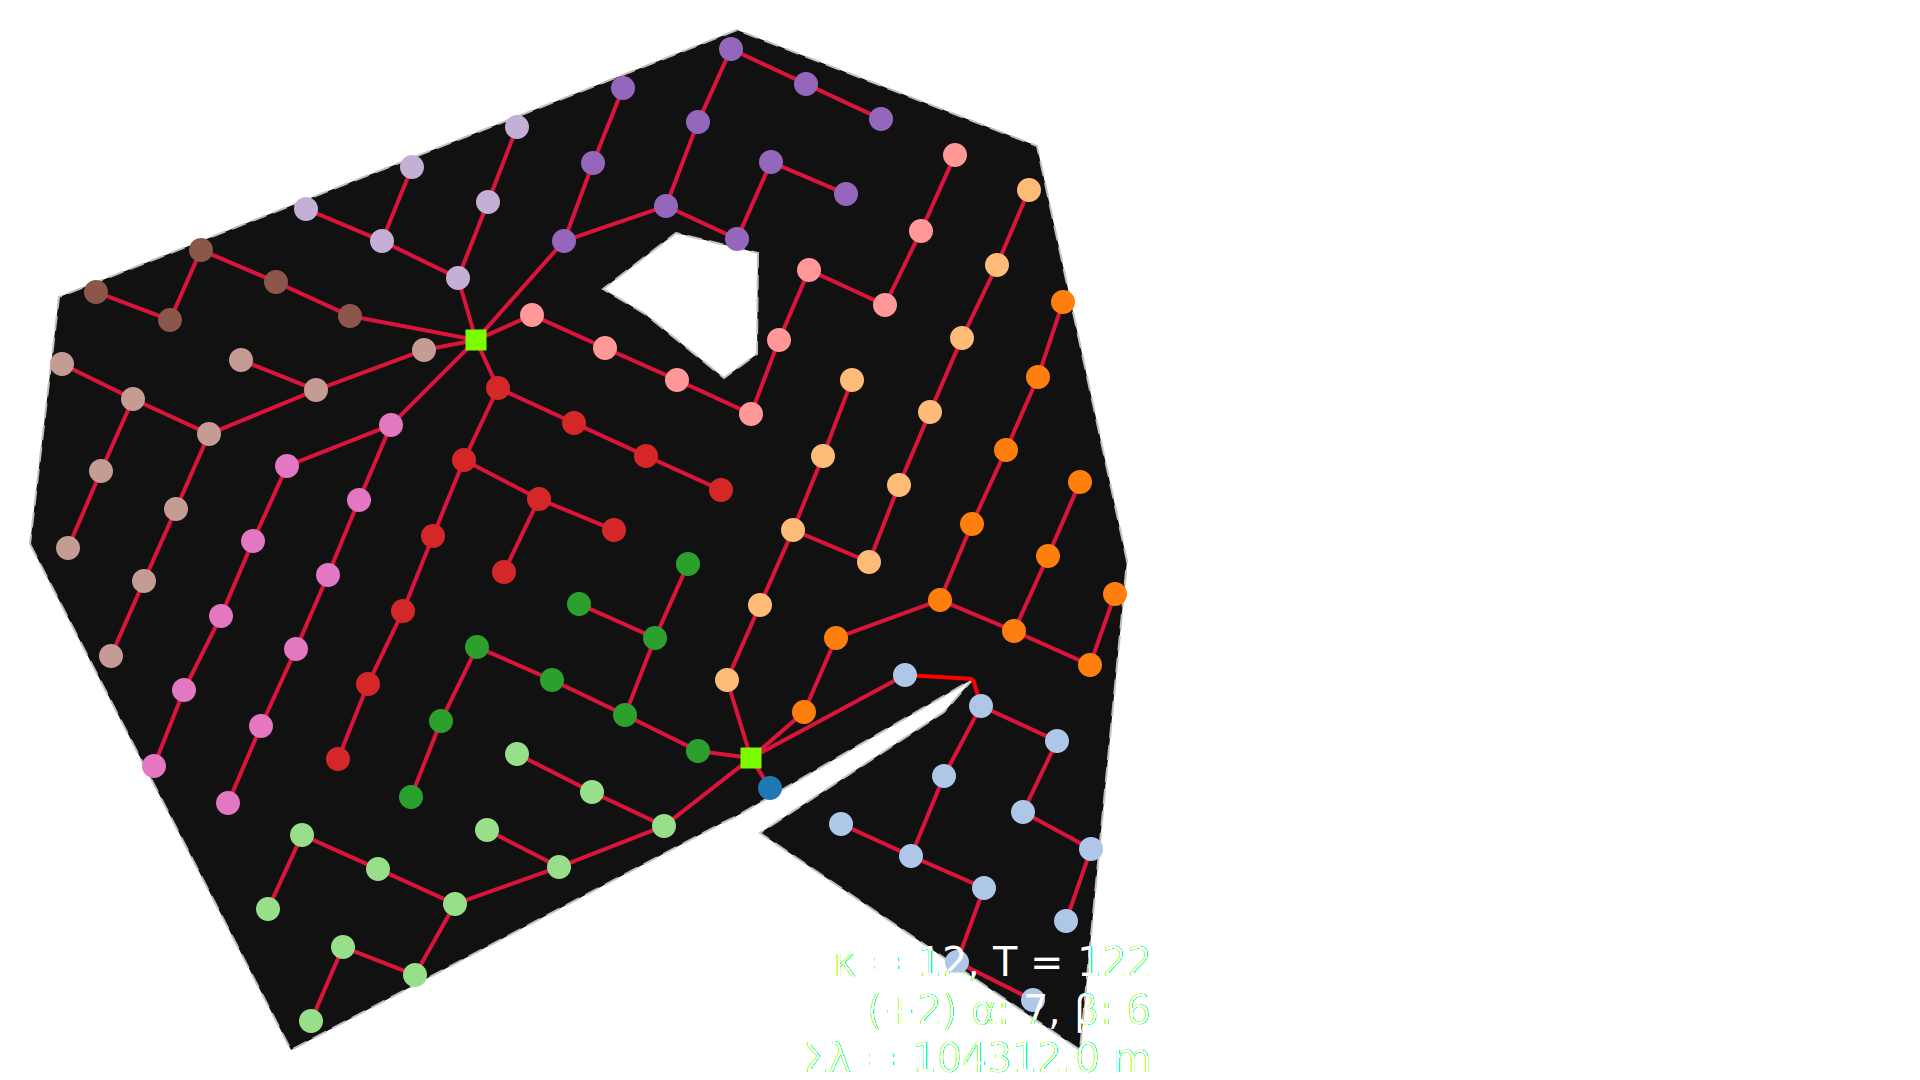

In [5]:
svgplot(G_ref)

## Start here

In [6]:
L = L_from_yaml(files('interarray.data') / 'Taylor-2023.yaml')

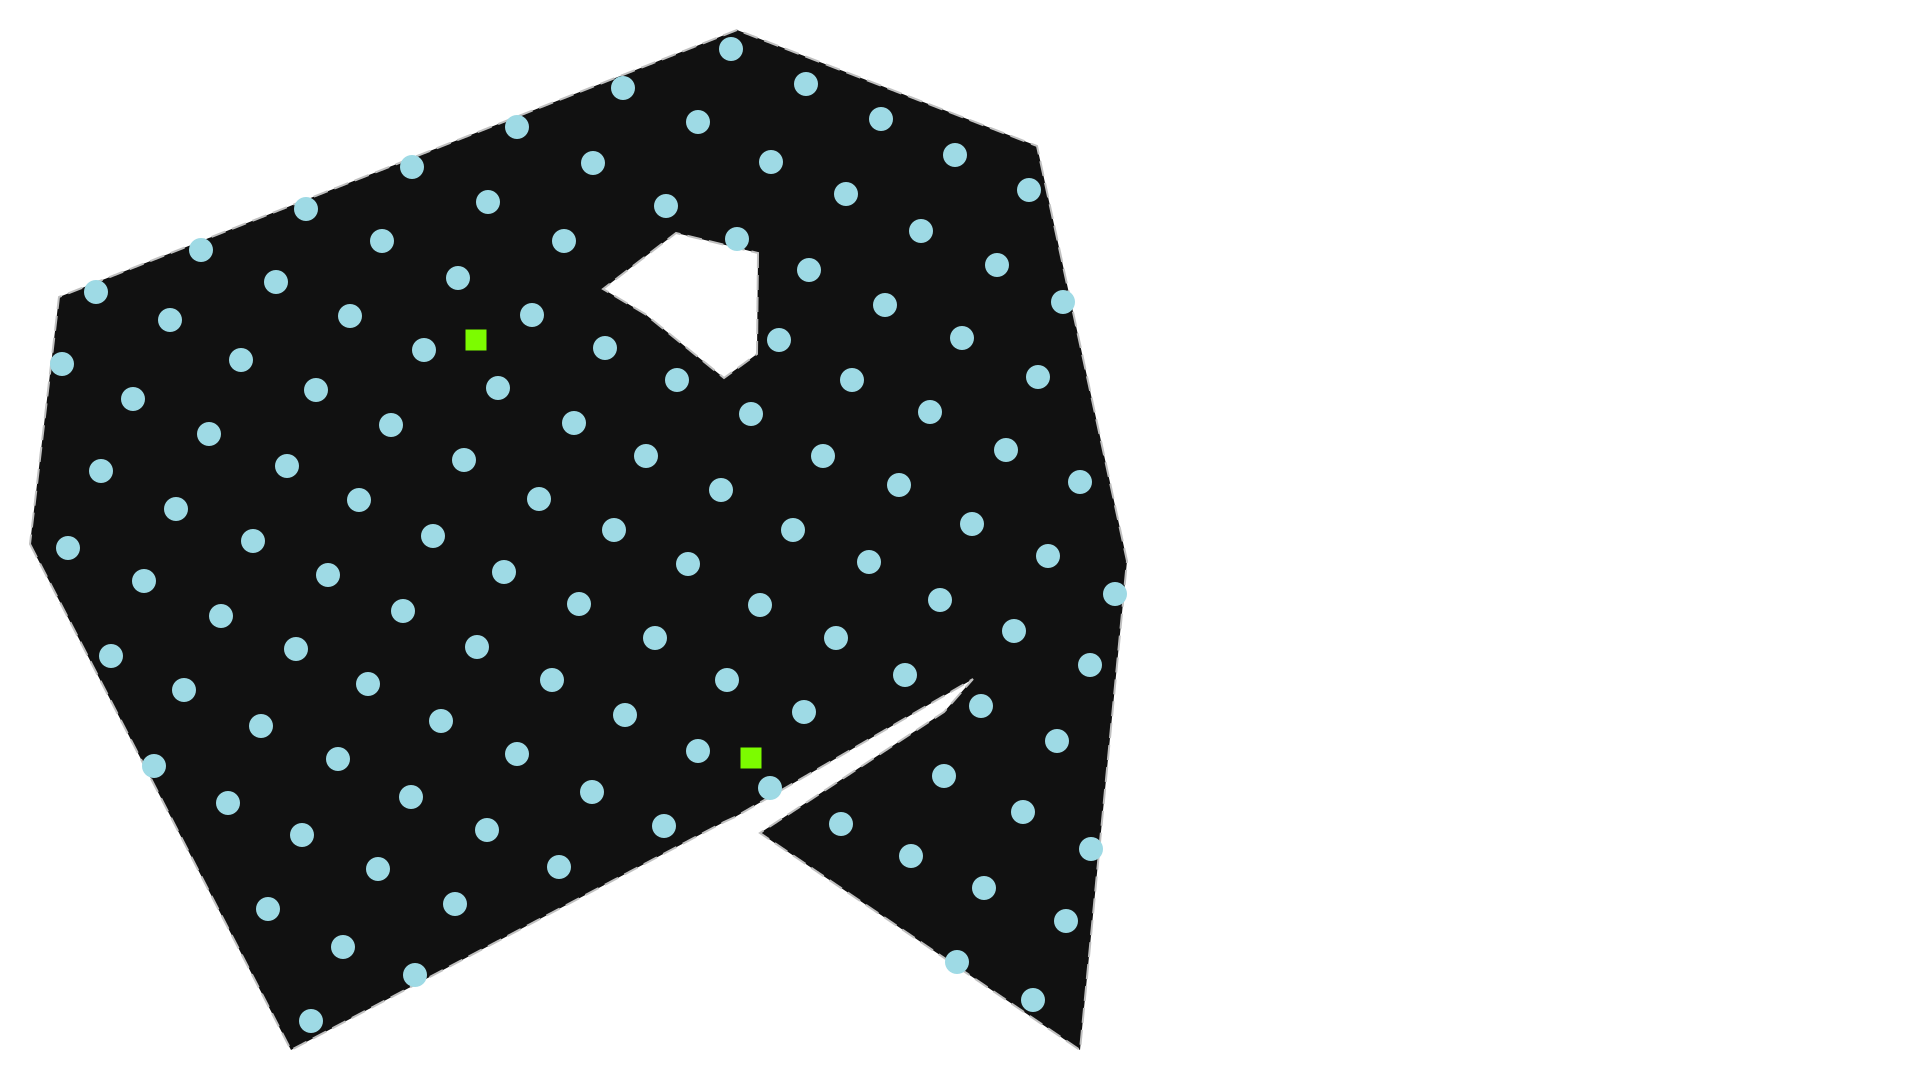

In [7]:
svgplot(L)

In [8]:
P, A = make_planar_embedding(L)

In [9]:
Sʹ = EW_presolver(A, 12)

In [10]:
Gʹ = G_from_S(Sʹ, A)

In [11]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

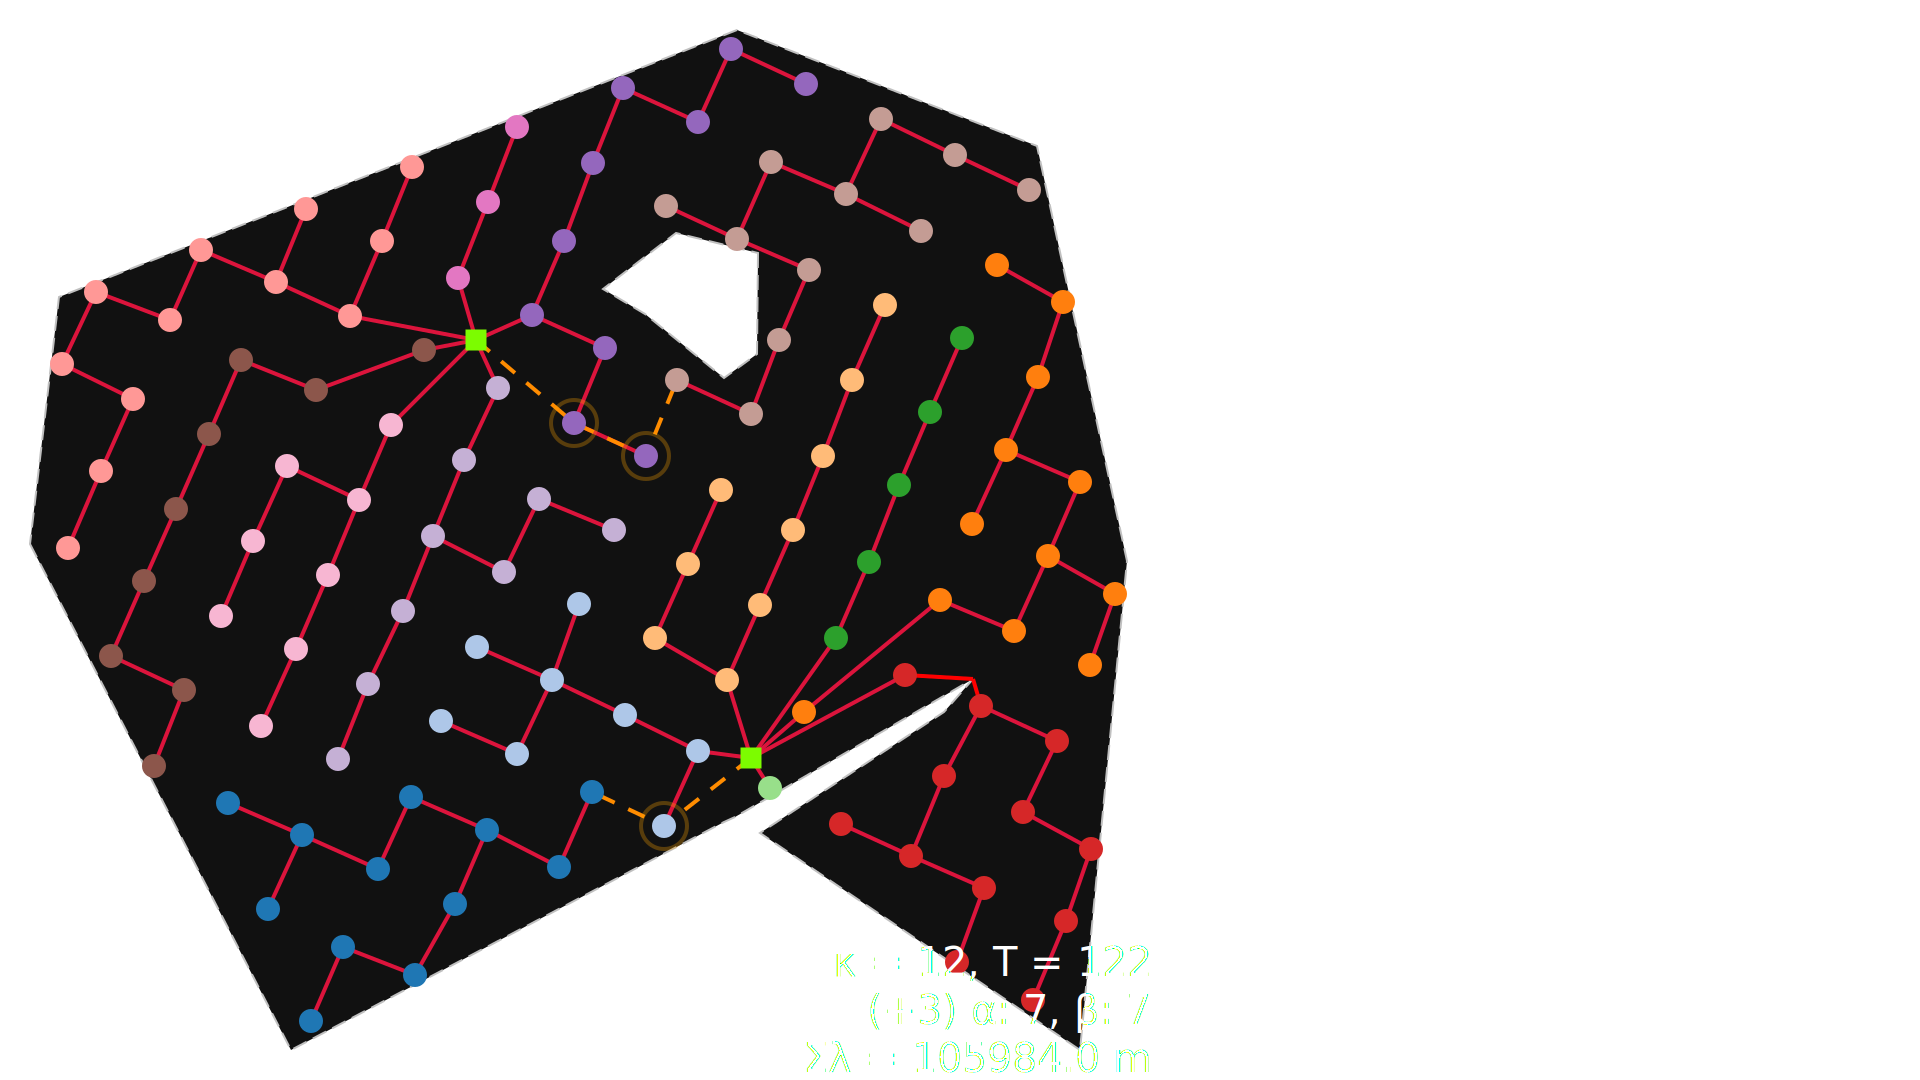

In [12]:
svgplot(Hʹ)

In [13]:
Sʹ = hgs_multiroot(A, capacity=12, time_limit=0.5)

In [14]:
Sʹ.graph['solution_time']

(0.19, 0.21)

In [15]:
Gʹ = G_from_S(Sʹ, A)

In [16]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

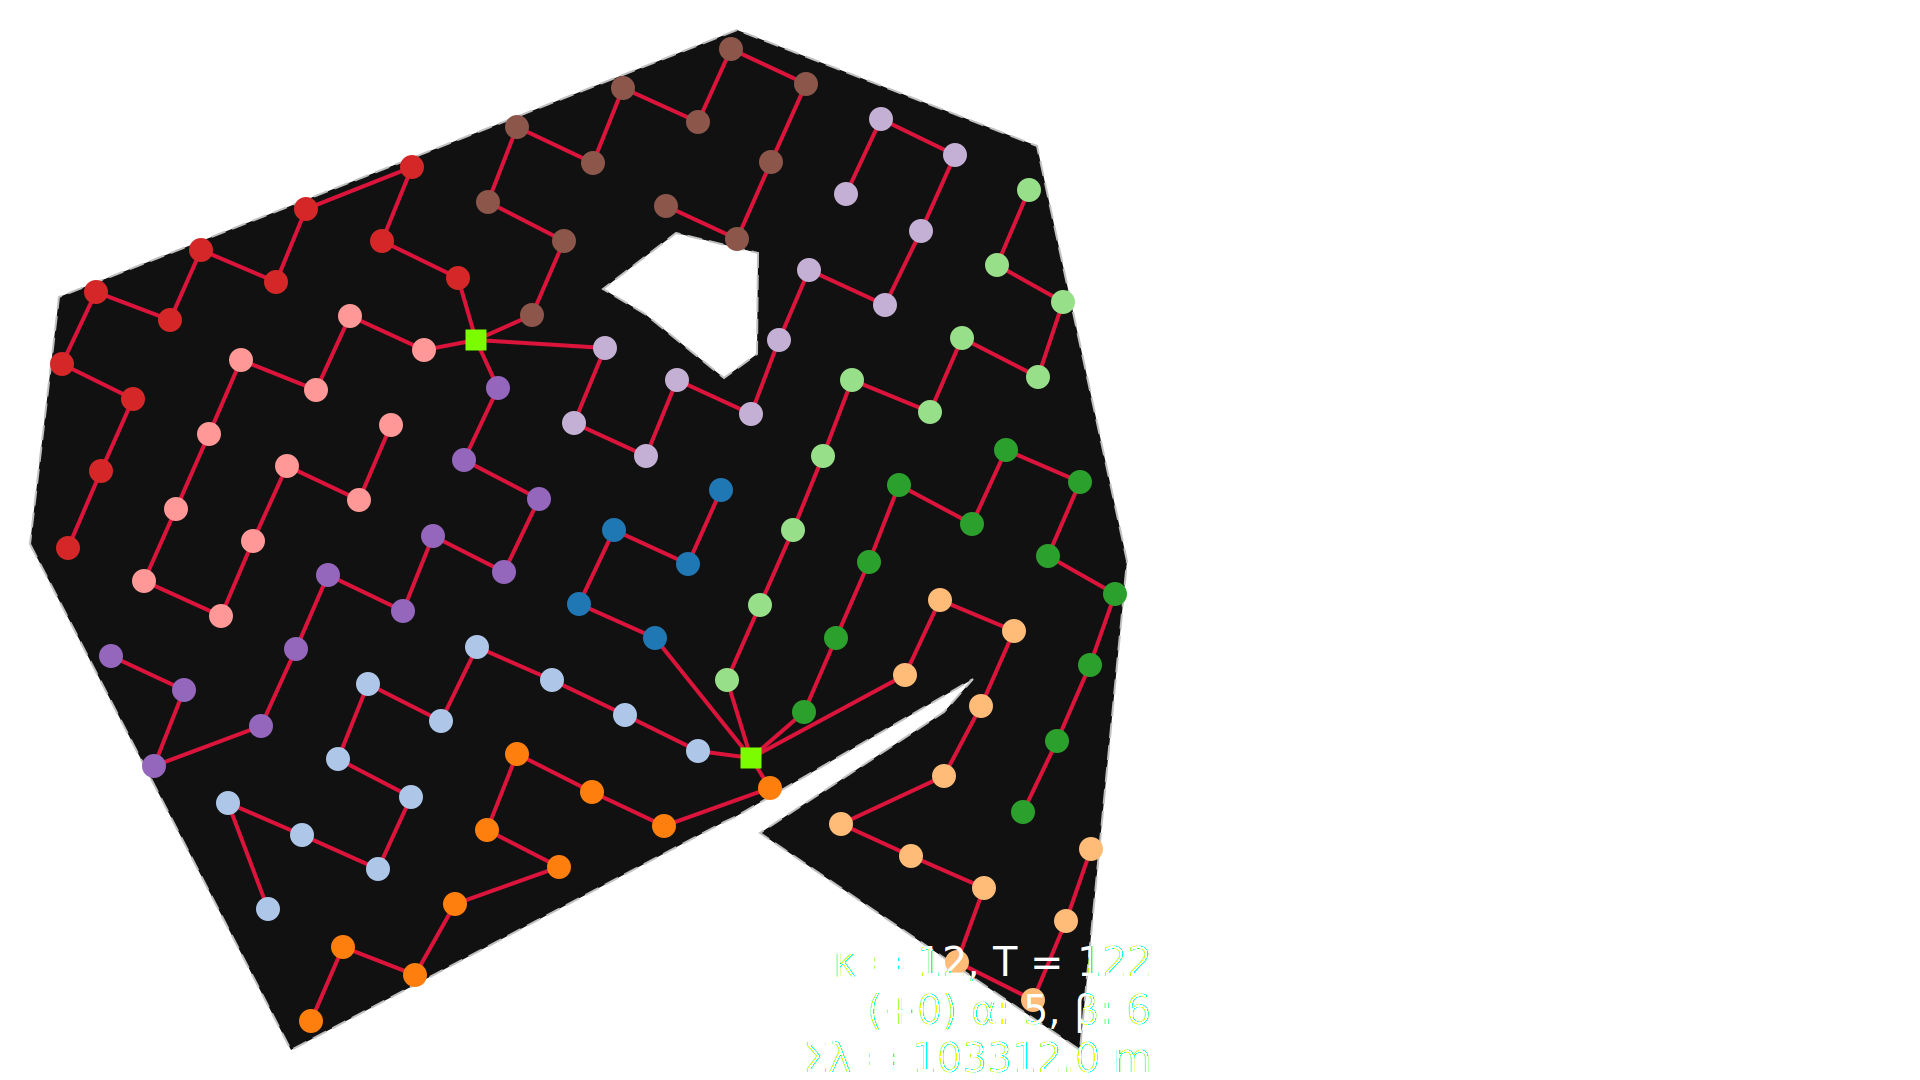

In [17]:
svgplot(Hʹ)

In [23]:
1 - Hʹ.size(weight='length')/G_ref.size(weight='length')

0.009587534447596746

In [24]:
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, Sʹ.graph['capacity'],
    gateXings_constraint=False,
    gates_limit=False,
    branching=True
)
omo.warmup_model(model, Sʹ)

In [25]:
solver.options.mipgap = 0.001  # 0.5 %
solver.options.timelimit = 5  # [s]
# solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=122, k=12}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.001
Set parameter TimeLimit to value 5
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  5
MIPGap  0.001

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4444 rows, 2896 columns and 16572 nonzeros
Model fingerprint: 0xffbdaa38
Variable types: 0 continuous, 2896 integer (1448 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e+02, 1e+04]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 103312

Presolve removed 653 rows and 0 columns
Presolve time: 0.02s
Presolved: 3791 rows, 2896 columns, 13820 n

In [26]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 100794.971
Pool investigation over - next best undetoured length: 100823.278


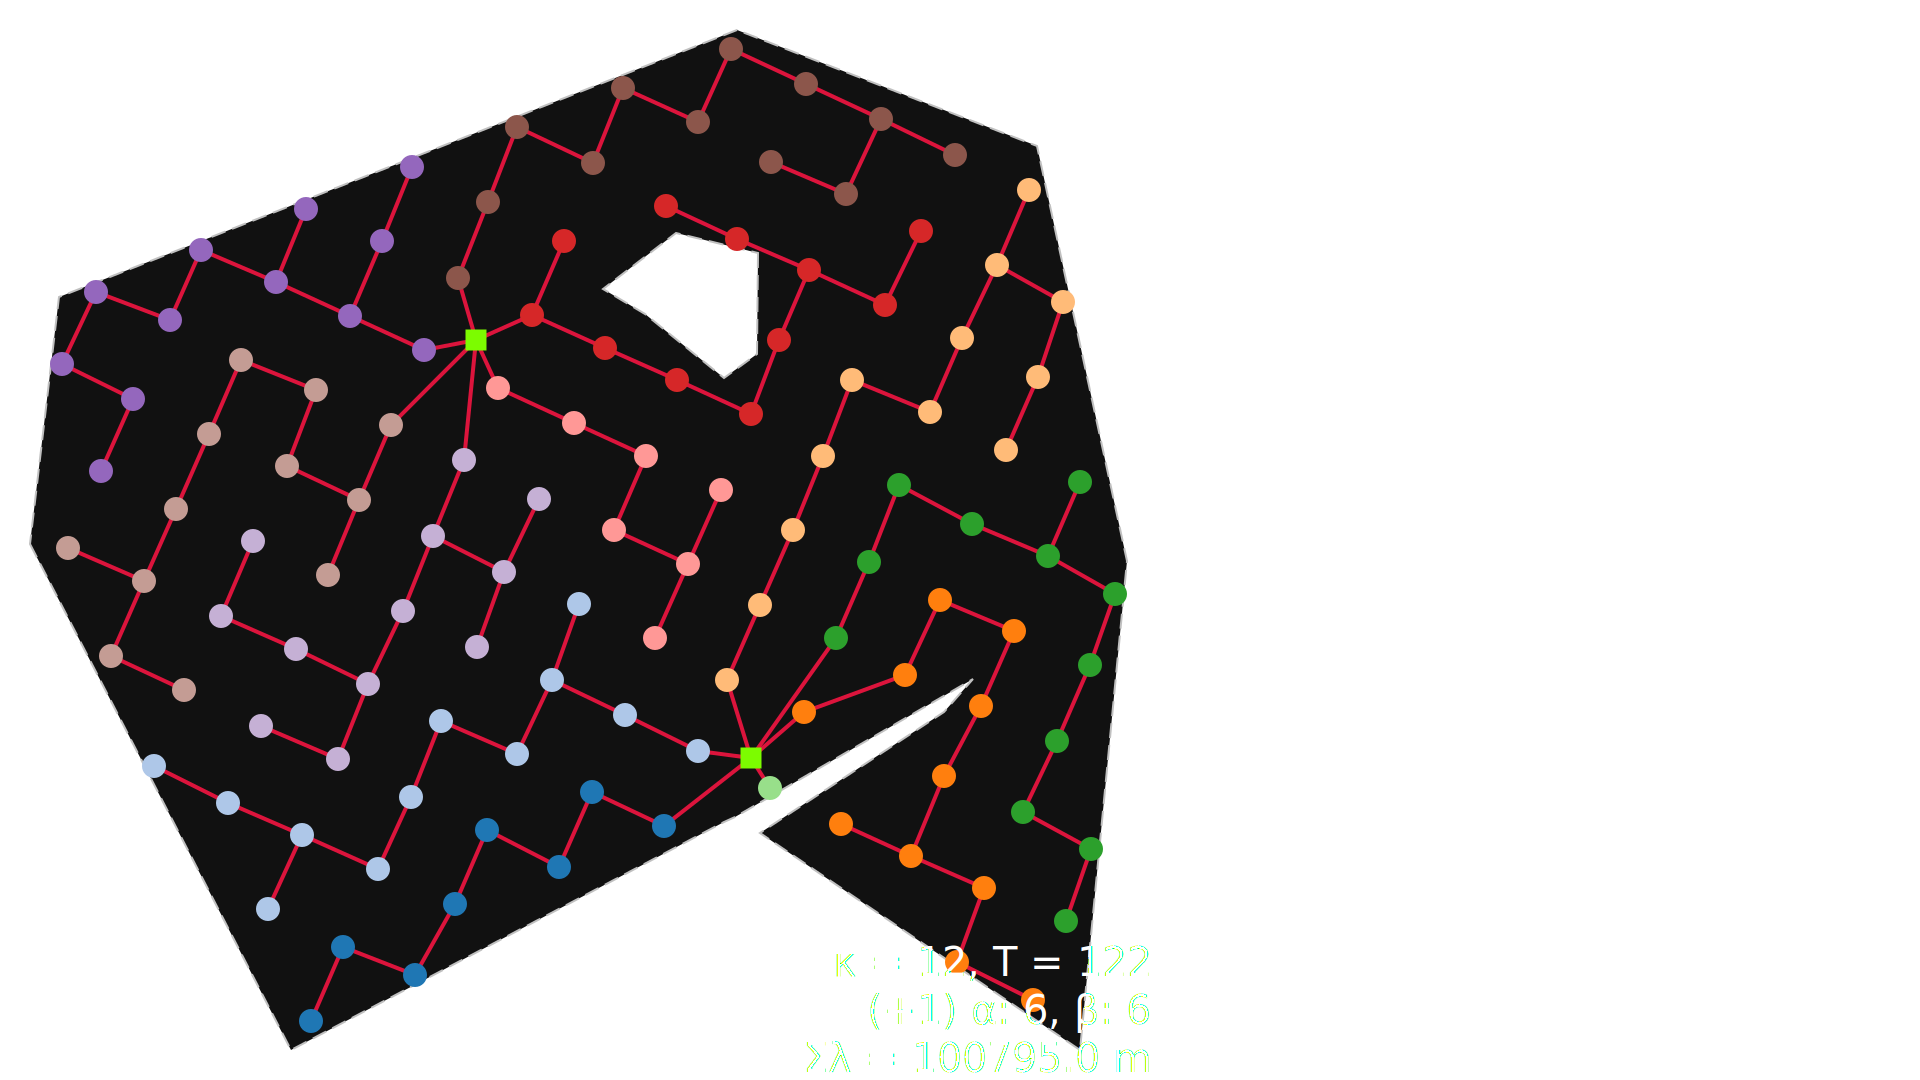

In [27]:
svgplot(H)

In [28]:
1 - H.size(weight='length')/G_ref.size(weight='length')

0.03371769751959075

In [30]:
with open('Taylor_comparison_κ_12_branched_ours.dill', 'wb') as outfile:
    dill.dump(H, outfile)